In [1]:
import sys
import os

import scipy.ndimage
import xarray as xr
import matplotlib.pyplot as plt
sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))    # So can access functions in isca_tools which is in home/Isca directory
import isca_tools
import numpy as np
from isca_tools.utils.land import get_ocean_coords, get_land_coords
from isca_tools.utils import area_weighting, lat_lon_slice
from isca_tools.land import write_land
from isca_tools.run.create_files import write_var, write_var

2025-02-06 10:20:58,656 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None
/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/run/create_files.py:328: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if time_interpolate is 'wrap':


## Write SST file
Take annual average of previous 5m depth experiment, take annual average so can use these fixed SSTs in new experiment.

In [4]:
isca_path = '/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/land/meridional_band/bucket_file/evap=0_1/'
write_var('bucket', isca_path, 'bucket', var_array=np.random.random((2, 3, 64, 128)), lat_var=2, lon_var=2, time_var=np.arange(2),
          pressure_var=np.asarray([0, 500, 1000]), pressure_interpolate=True)

/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/run/create_files.py:279: UserWarning: Values in var_val_array for pressure levels=[   0 1000]hPa
interpolated and output onto [220.72766 882.91064]hPa in output file.
  warnings.warn(f'Values in var_val_array for pressure levels={pressure_var[input_pressure_inds_for_out]}hPa\n'
/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/run/create_files.py:328: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if time_interpolate is 'wrap':
/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/run/create_files.py:328: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if time_interpolate is 'wrap':


NameError: name 'a' is not defined

In [5]:
b = xr.open_dataset('/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/run/grid_files/t42_grid.nc')

In [16]:
b = b.drop_dims(['pfull', 'phalf'])

In [17]:
b

<xarray.Dataset> Size: 2kB
Dimensions:  (lat: 64, lon: 128, latb: 65, lonb: 129)
Coordinates:
  * lat      (lat) float32 256B -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon      (lon) float32 512B 0.0 2.812 5.625 8.438 ... 351.6 354.4 357.2
  * latb     (latb) float32 260B -90.0 -86.58 -83.76 -80.96 ... 83.76 86.58 90.0
  * lonb     (lonb) float32 516B -1.406 1.406 4.219 7.031 ... 353.0 355.8 358.6
Data variables:
    *empty*

In [5]:
a = isca_tools.load_dataset('/Users/joshduffield/Desktop/k=1').bucket_depth

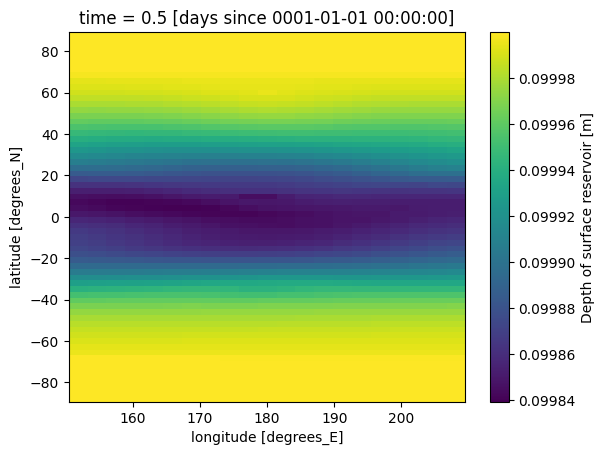

In [7]:
a.isel(time=0).sel(lon=slice(150, 210)).plot()

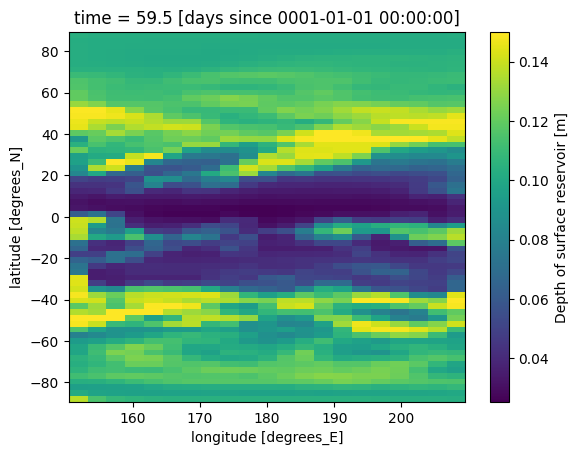

In [8]:
a.isel(time=-1).sel(lon=slice(150, 210)).plot()

In [2]:
# xr.load_dataset('zhang_example/sst.nc', decode_times=False)

In [26]:
# Load in SSTs from previous simulation, and take annual average to get SSTs to use
sst_file = 'tau_sweep/aquaplanet/k=1/'
use_time_start = 360*2
sst_use = isca_tools.load_dataset(sst_file)['t_surf']
sst_use = sst_use.sel(time=slice(use_time_start, np.inf))
sst_use = sst_use.mean(dim='time').load()

In [2]:
isca_path = '/Users/joshduffield/Documents/StAndrews/Isca/jobs/'
exp_dir = 'rossbypalooza/lat_10/1/'
exp_dir = 'rossbypalooza/depth=20/all_nh/lat_10/base/'
# write_sst(isca_path+exp_dir+'sst', isca_path+exp_dir+'namelist.nml', sst_use.to_numpy())

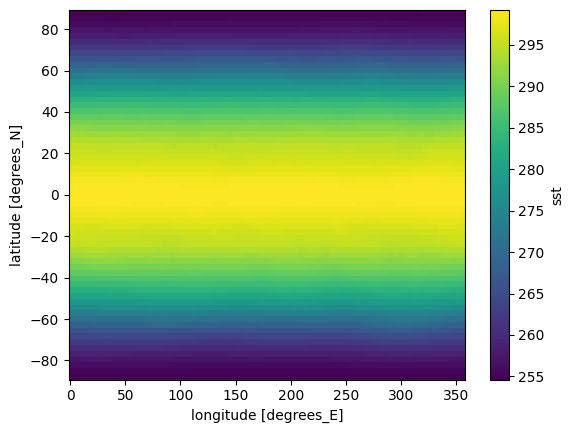

In [118]:
sst_saved = xr.load_dataset(isca_path+exp_dir+'sst.nc')
sst_saved.sst.plot()

## Create land
Create zonal strip of land in mid latitude to keep peak temperature near this region as vary rotation rate.

In [3]:
n_lat_land_cells = 4

lat_min = 10
lat_max = 90
# lat_min = 40
# lat_max = 80
write_land(isca_path+exp_dir+'land', isca_path+exp_dir+'namelist.nml', 'square', [lat_min, lat_max, 0-10, 360+10])

Output written to: /Users/joshduffield/Documents/StAndrews/Isca/jobs/rossbypalooza/depth=20/all_nh/lat_10/base/land.nc


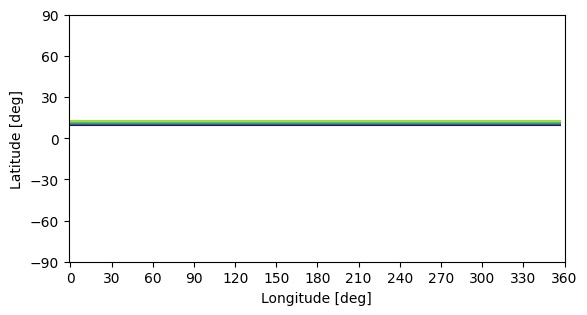

In [4]:
job_dir = os.path.join(os.path.dirname(os.environ['GFDL_DATA']), 'jobs')
land_file_name = os.path.join(job_dir, exp_dir, 'land.nc')
isca_tools.plot.show_land(land_file_name)

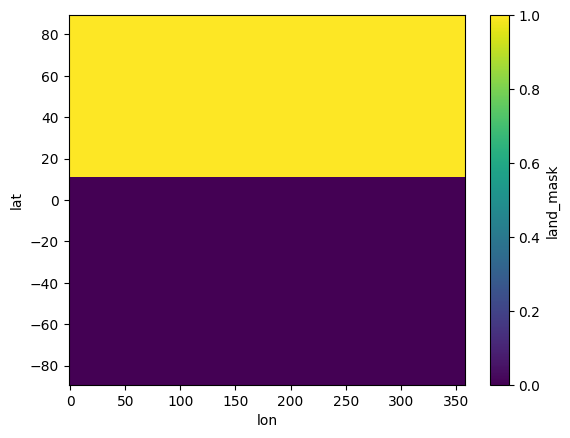

In [5]:
xr.load_dataset(land_file_name).land_mask.plot()

In [45]:
if float(xr.load_dataset(land_file_name).land_mask.isel(lon=0).sum()) != n_lat_land_cells:
    raise ValueError(f'Land mask has {float(xr.load_dataset(land_file_name).land_mask.isel(lon=0).sum())}, not {n_lat_land_cells} land lat coordinates')
else: 
    print(f'The land mask has {n_lat_land_cells} land latitudes')

The land mask has 4 land latitudes


## Sanity check that SST does not change with time
For land, it clearly does though.

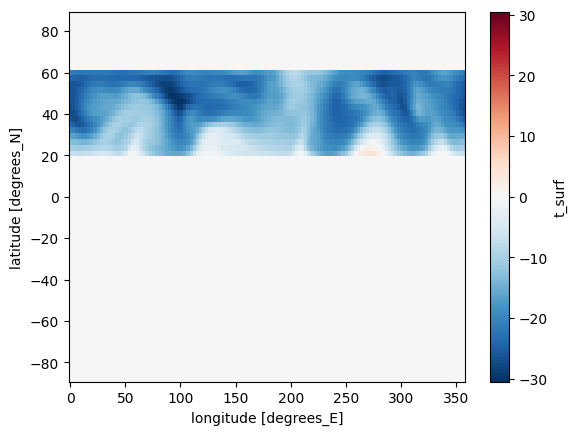

In [42]:
ds = isca_tools.load_dataset(exp_dir)['t_surf']
(ds.isel(time=-1)-ds.isel(time=0)).plot()

## Write SST file from observations
Below, I compare the Earth SST observations averaged from 1991-2020 to the aquaplanet. I then smooth the observed to use to generate the new SST array.

(0.0, 90.0)

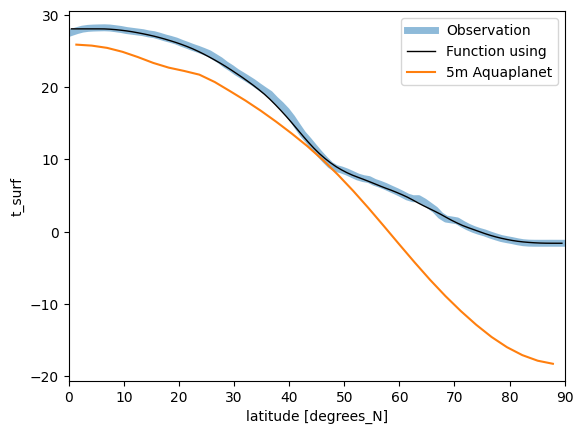

In [105]:
sst_obs = xr.load_dataset(isca_path+'/rossbypalooza/sst_observation/sst.oisst.mon.ltm.1991-2020.nc', 
                          decode_times=False).mean(dim=['lon', 'time']).sst

# Smooth observations - only consider observations
sst_obs_smooth = scipy.ndimage.convolve1d(sst_obs, np.ones(10)/10, mode='nearest')[sst_obs.lat>0]
if sst_obs_smooth.argmax() != 0:
    sst_obs_smooth[:sst_obs_smooth.argmax()] = sst_obs_smooth.max()         # make equatorial value the same as the max value
sst_obs[sst_obs.lat>0].plot(lw=5, alpha=0.5, label='Observation')
plt.plot(sst_obs.lat[sst_obs.lat>0], sst_obs_smooth, lw=1, color='k', label='Function using')
(sst_use.mean(dim='lon')-273.15)[sst_use.lat>0].plot(label='5m Aquaplanet')
plt.legend()
plt.xlim(0, 90)

In [107]:
# Generate SST array of same size as used in Isca, by using a previous namelist
sst_obs_to_save = np.interp(np.abs(sst_saved.lat), sst_obs.lat[sst_obs.lat>0], sst_obs_smooth)
sst_obs_to_save = np.tile(sst_obs_to_save[:, np.newaxis], [1, sst_saved.lon.size])          # Add longitude axis
sst_obs_to_save = sst_obs_to_save + 273.15  # convert to kelvin

# Save sst array
# write_sst('/Users/joshduffield/Desktop/sst.nc', isca_path+exp_dir+'namelist.nml', sst_obs_to_save)

ValueError: The file /Users/joshduffield/Desktop/sst.nc already exists. Delete or re-name this to continue.

## Write variable evaporative fraction file

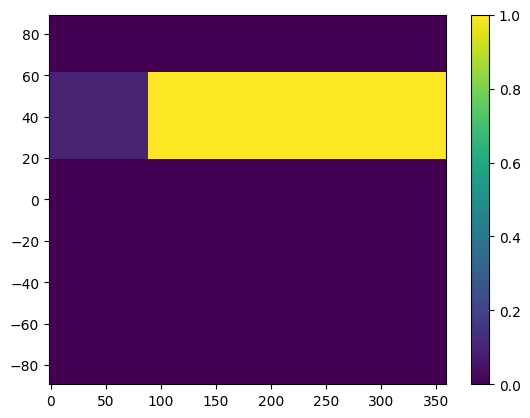

In [43]:
# zhang example
im = xr.load_dataset('/Users/joshduffield/Documents/StAndrews/Isca/modified_source_code/zhang_vary_evap_prefactor/land_evap_prefactor.nc')
plt.pcolormesh(im.lon, im.lat, im.land_evap_prefactor)
plt.colorbar()

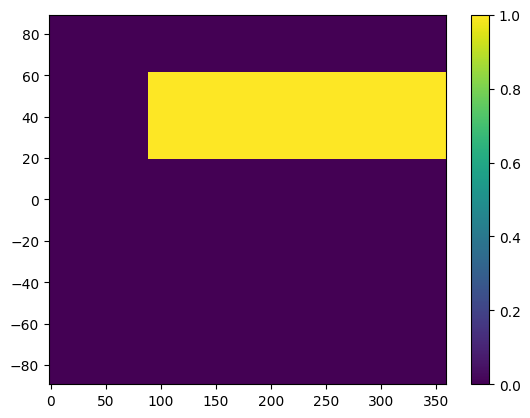

In [44]:
im = xr.load_dataset('/Users/joshduffield/Documents/StAndrews/Isca/jobs/rossbypalooza/variable_evap_flux/evap=0/land_evap_prefactor.nc')
plt.pcolormesh(im.lon, im.lat, im.land_evap_prefactor)
plt.colorbar()

In [45]:
# raw_values = im.land_evap_prefactor.to_numpy()